<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
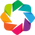

In [82]:
import os
import sys
sys.path.insert(0, os.path.abspath(r'D:\Code Repos\prey_capture'))

import paths
import functions_bondjango as bd
import functions_loaders as fl
import functions_plotting as fp
import snakemake_scripts.classify_batch as class_fun
import yaml
import processing_parameters
import datetime

import numpy as np
import pandas as pd
from sklearn import preprocessing
import sklearn.metrics as smet
import sklearn.linear_model as lin
import sklearn.model_selection as mod
import sklearn.svm as svm
import sklearn.multiclass as multi
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf

import h5py
import functions_misc as fm
import random
import scipy.stats as stat
import scipy.signal as signal
import importlib

import panel as pn
import holoviews as hv
from holoviews import opts, dim
hv.extension('bokeh')
from bokeh.resources import INLINE
from bokeh import palettes

In [272]:
# set up the figure config
importlib.reload(fp)
importlib.reload(processing_parameters)
# define the target saving path
save_path = os.path.join(paths.figures_path, 'Regression_prototype')

# define the printing mode
save_mode = True
# define the target document
target_document = 'poster'
# set up the figure theme
fp.set_theme()
# load the label dict
label_dict = processing_parameters.label_dictionary
variable_list = processing_parameters.variable_list
units_dict = processing_parameters.tc_units

In [5]:
# load the target files

# get the search string
animal = processing_parameters.animal
day = processing_parameters.day
rig = processing_parameters.rig
search_string = 'imaging:doric, slug:%s' % day

# query the database for data to plot
data_all = bd.query_database('analyzed_data', search_string)

input_path = [el['analysis_path'] for el in data_all if ('preproc' in el['slug'] and animal.lower() in el['slug'])]
print(input_path)

['J:\\Drago Guggiana Nilo\\Prey_capture\\AnalyzedData\\04_02_2021_10_34_47_miniscope_DG_210202_a_succ_preproc.hdf5', 'J:\\Drago Guggiana Nilo\\Prey_capture\\AnalyzedData\\04_02_2021_10_30_38_miniscope_DG_210202_a_succ_preproc.hdf5', 'J:\\Drago Guggiana Nilo\\Prey_capture\\AnalyzedData\\04_02_2021_10_25_41_miniscope_DG_210202_a_succ_preproc.hdf5', 'J:\\Drago Guggiana Nilo\\Prey_capture\\AnalyzedData\\04_02_2021_10_21_22_miniscope_DG_210202_a_succ_preproc.hdf5', 'J:\\Drago Guggiana Nilo\\Prey_capture\\AnalyzedData\\04_02_2021_10_16_10_miniscope_DG_210202_a_succ_preproc.hdf5', 'J:\\Drago Guggiana Nilo\\Prey_capture\\AnalyzedData\\04_02_2021_10_10_35_miniscope_DG_210202_a_succ_preproc.hdf5', 'J:\\Drago Guggiana Nilo\\Prey_capture\\AnalyzedData\\04_02_2021_10_06_47_miniscope_DG_210202_a_succ_preproc.hdf5', 'J:\\Drago Guggiana Nilo\\Prey_capture\\AnalyzedData\\04_02_2021_10_03_36_miniscope_DG_210202_a_succ_preproc.hdf5']


In [6]:
# load the data
data_list = []
meta_list = []
frame_list = []
for idx, el in enumerate(input_path):
    # get the trial timestamp (for frame calculations)
    time_stamp = int(''.join(os.path.basename(el).split('_')[3:6]))
    # also get the trial time signature, used as unique ID
    # time_signature = int(''.join(os.path.basename(el).split('_')[0:6]))

    try:
        temp_data = pd.read_hdf(el, 'matched_calcium')
        # temp_data['trial_id'] = time_signature
        temp_data['id'] = data_all[idx]['id']

        meta_list.append([data_all[idx][el1] for el1 in processing_parameters.meta_fields])
        # try to load the motifs and latents
        try:
            latents = pd.read_hdf(el, 'latents')
            motifs = pd.read_hdf(el, 'motifs')
            egocentric_coords = pd.read_hdf(el, 'egocentric_coord')
            egocentric_coords = egocentric_coords.loc[:, ['cricket_0_x', 'cricket_0_y']]
            egocentric_coords = egocentric_coords.rename(columns={'cricket_0_x': 'ego_cricket_x',
                                                                  'cricket_0_y': 'ego_cricket_y'})
            # pad the latents
            [latents, motifs] = fl.pad_latents([latents, motifs], temp_data.shape[0])
            # concatenate with the main data
            temp_data = pd.concat([temp_data, egocentric_coords, latents, motifs], axis=1)
        except KeyError:
            print(f'No latents in file {el}')
        data_list.append(temp_data)
        frame_list.append([time_stamp, 0, temp_data.shape[0]])
    except KeyError:
        # data_list.append([])
        frame_list.append([time_stamp, 0, 0])

In [230]:
%%time
# define the regression parameters and perform the regression
importlib.reload(class_fun)
# parameters
target_behavior = 'mouse_speed'
time_shift = 0
chunk = True
repeats = 10
shuffle_f = False
chunk_size = 0.05
chunk_size_shuffle = 0.05

# get the cell labels
labels = list(np.unique(np.array([el.columns for el in data_list]).flatten()))
cells = [el for el in labels if 'cell' in el]
# get the data
sub_data = [el[[target_behavior]+cells] for el in data_list if (target_behavior in el.columns)]
sub_data = pd.concat(sub_data)
# get the parameter of interest
parameter_working = sub_data.loc[:, target_behavior].to_numpy().copy()
calcium_data_working = np.array(sub_data[cells].copy())

# # bin the parameter
# parameter_working = stat.binned_statistic(parameter_working, parameter_working, bins=10, statistic='count')[2]

# allocate lists for the outputs
pred_list = []
coeff_list = []
score_list = []
# for all the repeats
for reps in np.arange(repeats):
    # create the regressor
    regressor = lin.TweedieRegressor(alpha=0.01, max_iter=5000, fit_intercept=False, power=0)
#     regressor = AutoReg(lags=1)
#     regressor = lin.MultiTaskElasticNetCV(max_iter=5000, l1_ratio=[.1, .5, .7, .9, .95, .99, 1], 
#                            n_jobs=7, alphas=[.0001, .01, .1, 1, 10, 100], fit_intercept=True)
#                            n_jobs=7, alphas=[.001])
#     regressor = lin.HuberRegressor(alpha=.1, max_iter=5000, fit_intercept=True, epsilon=10)
#     regressor = svm.SVR(max_iter=10000, kernel='rbf', C=100)
#     regressor = svm.LinearSVR(max_iter=5000, C=100)
#     regressor = svm.LinearSVC(max_iter=1000, C=1000, class_weight='balanced')
#     regressor = svm.SVC(max_iter=10000, C=.1, class_weight='balanced', kernel='rbf')

    # run the training function
    linear_pred, coefficients, cc_score = class_fun.train_test_regressor(parameter_working,
                                                                         calcium_data_working,
                                                                         preprocessing.StandardScaler,
                                                                         regressor,
                                                                         stat.spearmanr,
#                                                                          smet.r2_score,
#                                                                          smet.accuracy_score,
                                                                         shuffle_f=shuffle_f,
                                                                         time_s=time_shift,
                                                                         shuffle=False,
                                                                         empty=False,
                                                                         chunk=chunk,
                                                                         chunk_size=chunk_size,
                                                                         chunk_size_shuffle=chunk_size_shuffle,
                                                                         test_size=0.3)

    pred_list.append(linear_pred)
    coeff_list.append(coefficients)
    score_list.append(cc_score)
print(f'Mean correlation: {np.mean(score_list)}')
print(f'Correlation of the mean prediction: {stat.spearmanr(parameter_working[time_shift:], np.mean(pred_list, axis=0))[0]}')


Mean correlation: 0.25882507409920547
Correlation of the mean prediction: 0.5189770174631588
Wall time: 563 ms


In [244]:
# print(np.array(pred_list)[:, trial_range].shape)
print(data_list[0].columns[:50])

Index(['mouse_snout_x', 'mouse_snout_y', 'mouse_barl_x', 'mouse_barl_y',
       'mouse_barr_x', 'mouse_barr_y', 'mouse_head_x', 'mouse_head_y',
       'mouse_x', 'mouse_y', 'mouse_body2_x', 'mouse_body2_y', 'mouse_body3_x',
       'mouse_body3_y', 'mouse_base_x', 'mouse_base_y', 'mouse_heading',
       'mouse_angular_speed', 'mouse_speed', 'mouse_acceleration',
       'head_direction', 'cricket_0_x', 'cricket_0_y', 'cricket_0_heading',
       'cricket_0_speed', 'cricket_0_acceleration', 'cricket_0_mouse_distance',
       'cricket_0_delta_heading', 'cricket_0_size', 'cricket_0_delta_head',
       'cricket_0_quadrant', 'cricket_0_visual_angle', 'cricket_0_direction',
       'cricket_0_loom', 'cricket_0_delta_visual', 'cricket_0_head_x',
       'cricket_0_head_y', 'hunt_trace', 'time_vector', 'mouse', 'datetime',
       'cell_0000', 'cell_0001', 'cell_0002', 'cell_0003', 'cell_0004',
       'cell_0005', 'cell_0006', 'cell_0007', 'cell_0008'],
      dtype='object')


# Regression example plot 

In [273]:
# plot the predictions

importlib.reload(fp)
plot_list = []

# define the section of the trial to plot
trial_range = np.arange(500)
target_stretch = np.array(pred_list)[:, trial_range]
target_time = []
for idx, el in enumerate(data_list):
    if idx == 0:
        target_time.append(el['time_vector'].to_numpy())
    else:
        temp_time = el['time_vector'].to_numpy()
        target_time.append(temp_time + target_time[-1][-1])
            
#     target_time = pd.concat([el['time_vector'] for el in data_list], axis=0)

# x = np.arange(target_stretch.shape[1])
x = np.concatenate(target_time, axis=0)[trial_range]
# # for all the repeats
# for reps in np.arange(repeats):
#     plot = hv.Curve((x, pred_list[reps]))
#     plot.opts(width=1000)
#     plot_list.append(plot)
# also plot the sem for each time point
mean = np.mean(target_stretch, axis=0)
# sem = stat.sem(pred_list, axis=0)
std = np.std(target_stretch, axis=0)
plot = hv.Spread((x, mean, std)).opts(color='blue')
mean_plot = hv.Curve((x, mean))
mean_plot.opts(color='blue', line_dash='dotted')
plot_list.append(plot)
plot_list.append(mean_plot)
# and the original trace
# param_plot = parameter_working[~np.isnan(parameter_working)].copy()
param_plot = parameter_working.copy()
if time_shift >= 0:
    y = param_plot[time_shift:].copy()
else:
    y = param_plot[:time_shift].copy()
y = y[trial_range]

plot = hv.Curve((x, y))
# plot.opts(line_dash='dotted', title=f'Mean cc: {np.mean(score_list):0.2f}')
plot.opts(color='black')
plot_list.append(plot)
    
plot_overlay = hv.Overlay(plot_list)
plot_overlay.opts(opts.Curve(width=1000, height=300, xlabel='Time (s)', ylabel=' '.join((label_dict[target_behavior], units_dict[target_behavior]))))

# assemble the file name
save_name = os.path.join(save_path, '_'.join((target_document, 'Reg_ex')) + '.png')
# save the figure
fig = fp.save_figure(plot_overlay, save_name, fig_width=23, dpi=1200, fontsize=target_document, target='save')


Figure saved!: J:\Drago Guggiana Nilo\Prey_capture\Figures\Regression_prototype\poster_Reg_ex.png


In [8]:
# plot the weights

plot_list = []

x = np.arange(coeff_list[0].shape[0])
# for all the repeats
for reps in np.arange(repeats):
    plot = hv.Scatter((x, coeff_list[reps]))
    plot.opts(width=1000, size=10)
    plot_list.append(plot)
# also plot the sem for each weight
mean = np.mean(coeff_list, axis=0)
# sem = stat.sem(coeff_list, axis=0)
std = np.std(coeff_list, axis=0)
plot = hv.ErrorBars((x, mean, std))
plot.opts(title=f'Average weight std: {np.mean(std):0.2f}')
plot_list.append(plot)

hv.Overlay(plot_list)

:Overlay
   .Scatter.I   :Scatter   [x]   (y)
   .Scatter.II  :Scatter   [x]   (y)
   .Scatter.III :Scatter   [x]   (y)
   .Scatter.IV  :Scatter   [x]   (y)
   .Scatter.V   :Scatter   [x]   (y)
   .ErrorBars.I :ErrorBars   [x]   (y,yerror)

In [9]:
# Plot importance index

# plot_list = []

x = np.arange(coeff_list[0].shape[0])
# # for all the repeats
# for reps in np.arange(repeats):
#     plot = hv.Scatter((x, coeff_list[reps]))
#     plot.opts(width=1000, size=10)
#     plot_list.append(plot)

importance_list = []
# for all of the repeats
for reps in np.arange(repeats):
    importance_list.append(coeff_list[reps]/np.sum(coeff_list[reps]))
# also plot the sem for each weight
importance = np.sum(coeff_list, axis=0)
# sem = stat.sem(coeff_list, axis=0)
# std = np.std(coeff_list, axis=0)
# plot = hv.ErrorBars((x, mean, std))
plot = hv.Curve((x, importance))
plot.opts(title=f'Average weight std: {np.mean(std):0.2f}')
plot_list.append(plot)

hv.Overlay(plot_list)

:Overlay
   .Scatter.I   :Scatter   [x]   (y)
   .Scatter.II  :Scatter   [x]   (y)
   .Scatter.III :Scatter   [x]   (y)
   .Scatter.IV  :Scatter   [x]   (y)
   .Scatter.V   :Scatter   [x]   (y)
   .ErrorBars.I :ErrorBars   [x]   (y,yerror)
   .Curve.I     :Curve   [x]   (y)

In [225]:
%%time
# calculate regression over time

importlib.reload(class_fun)
# parameters
target_behavior = 'cricket_0_x'
time_shift = [-40, -30, -20, -10, 0, 10, 20, 30, 40]
# time_shift = [-10, 0, 10]
# time_shift = [-15, -10, -5, 0, 5, 10, 15]
chunk = True
repeats = 100
# shuffle = True
chunk_size = 0.05
chunk_size_shuffle = 0.05

# get the cell labels
labels = list(np.unique(np.array([el.columns for el in data_list]).flatten()))
cells = [el for el in labels if 'cell' in el]
# get the data
sub_data = [el[[target_behavior]+cells] for el in data_list if (target_behavior in el.columns)]
sub_data = pd.concat(sub_data)
# get the parameter of interest
parameter_working = sub_data.loc[:, target_behavior].to_numpy().copy()
calcium_data_working = np.array(sub_data[cells].copy())

# # bin the parameter
# parameter_working = stat.binned_statistic(parameter_working, parameter_working, bins=10, statistic='count')[2]

# allocate memory for the shuffles
pred_shuffle = []
coeff_shuffle = []
score_shuffle = []
# for real and shuffle
for realvshuffle in np.arange(2):
    
    if realvshuffle == 0:
        shuffle_f = False
    else:
        shuffle_f = True
    # allocate lists for the outputs
    pred_time = []
    coeff_time = []
    score_time = []
    # for all the time shifts
    for time_s in time_shift:
        pred_list = []
        coeff_list = []
        score_list = []
        # for all the repeats
        for reps in np.arange(repeats):
            # create the regressor
            regressor = lin.TweedieRegressor(alpha=0.01, max_iter=5000, fit_intercept=False, power=0)
#             regressor = lin.MultiTaskElasticNetCV(max_iter=5000, l1_ratio=[.1, .5, .7, .9, .95, .99, 1], 
#                                    n_jobs=7, alphas=[.0001, .01, .1, 1, 10, 100], fit_intercept=True)
#                                    n_jobs=7, alphas=[.001])
#             regressor = lin.HuberRegressor(alpha=.1, max_iter=5000, fit_intercept=True, epsilon=10)
#             regressor = svm.SVR(max_iter=10000, kernel='rbf', C=100)
#             regressor = svm.LinearSVR(max_iter=5000, C=100)
#             regressor = svm.LinearSVC(max_iter=1000, C=1000, class_weight='balanced')
#             regressor = svm.SVC(max_iter=1000, C=.1, class_weight='balanced', kernel='rbf')
#             regressor = multi.OutputCodeClassifier(estimator=regressor, code_size=1, n_jobs=-1)

            # run the training function
            linear_pred, coefficients, cc_score = class_fun.train_test_regressor(parameter_working,
                                                                                 calcium_data_working,
                                                                                 preprocessing.StandardScaler,
                                                                                 regressor,
                                                                                 stat.spearmanr,
#                                                                                  smet.r2_score,
#                                                                                  smet.accuracy_score,
                                                                                 time_s=time_s,
                                                                                 shuffle_f=shuffle_f,
                                                                                 empty=False,
                                                                                 chunk=chunk,
                                                                                 test_size=0.3,
                                                                                 shuffle=False,
                                                                                 chunk_size=chunk_size,
                                                                                 chunk_size_shuffle=chunk_size_shuffle)
                                                                                 
            pred_list.append(linear_pred)
            coeff_list.append(coefficients)
            score_list.append(cc_score)
        pred_time.append([np.mean(pred_list, axis=0), np.std(pred_list, axis=0)])
        coeff_time.append([np.mean(coeff_list, axis=0), np.std(coeff_list, axis=0)])
        score_time.append([np.mean(score_list), np.std(score_list)])
#         # get the score
#         param_plot = parameter_working[~np.isnan(parameter_working)].copy()
#         if time_s >= 0:
#             param_plot = param_plot[time_s:].copy()
#         else:
#             param_plot = param_plot[:time_s].copy()
#         score_of_mean = stat.spearmanr(param_plot, pred_time[-1][0])[0]
#         score_of_std = stat.spearmanr(param_plot, pred_time[-1][1])[0]
#         score_time.append([score_of_mean, score_of_std])
    pred_shuffle.append(pred_time)
    coeff_shuffle.append(coeff_time)
    score_shuffle.append(score_time)
print(np.mean(score_list))

0.012297622931258228
Wall time: 1min 11s


In [226]:
# plot the results over time

plot_list = []
mean = hv.Scatter((time_shift, [el[0] for el in score_shuffle[0]]), kdims='Time shift', vdims='Activity')
std = hv.Spread((time_shift, [el[0] for el in score_shuffle[0]], [el[1] for el in score_shuffle[0]]))
mean.opts(width=1000, color='red', title=target_behavior)
std.opts(width=1000, color='red')
plot_list.append(mean*std)
mean = hv.Scatter((time_shift, [el[0] for el in score_shuffle[1]]))
std = hv.Spread((time_shift, [el[0] for el in score_shuffle[1]], [el[1] for el in score_shuffle[1]]))
mean.opts(width=1000, color='black')
std.opts(width=1000, color='black')
plot_list.append(mean*std)
hv.Overlay(plot_list)


:Overlay
   .Scatter.I  :Scatter   [Time shift]   (Activity)
   .Spread.I   :Spread   [x]   (y,yerror)
   .Scatter.II :Scatter   [x]   (y)
   .Spread.II  :Spread   [x]   (y,yerror)

In [123]:
# compute the autocorrelation of a given variable

plot_list = []
autocorrelation = signal.correlate(parameter_working, parameter_working, 'same')
x = np.arange(-autocorrelation.shape[0]/2, autocorrelation.shape[0]/2)
plot = hv.Curve((x, autocorrelation))
plot.opts(width=1000, color='red')
plot_list.append(plot)
for reps in np.arange(repeats):
    parameter_shuffle = class_fun.chunk_shuffle(parameter_working, chunk_size_shuffle=0.01)
#     print(parameter_shuffle)
    auto_shuffle = signal.correlate(parameter_shuffle, parameter_shuffle, 'same')
    plot = hv.Curve((x, auto_shuffle))
    plot.opts(width=1000, color='black')
    plot_list.append(plot)

hv.Overlay(plot_list)

:Overlay
   .Curve.I    :Curve   [x]   (y)
   .Curve.II   :Curve   [x]   (y)
   .Curve.III  :Curve   [x]   (y)
   .Curve.IV   :Curve   [x]   (y)
   .Curve.V    :Curve   [x]   (y)
   .Curve.VI   :Curve   [x]   (y)
   .Curve.VII  :Curve   [x]   (y)
   .Curve.VIII :Curve   [x]   (y)
   .Curve.IX   :Curve   [x]   (y)
   .Curve.X    :Curve   [x]   (y)
   .Curve.XI   :Curve   [x]   (y)